<a href="https://colab.research.google.com/github/jal9o3/OLA/blob/dev/OLA_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define the neural network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

INPUT_SIZE = 147
OUTPUT_SIZE = 254

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, OUTPUT_SIZE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)  # Apply softmax along the appropriate dimension
        return x

class FiveLayer(nn.Module):
    def __init__(self):
        super(FiveLayer, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, OUTPUT_SIZE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.softmax(x, dim=1)

class TenLayer(nn.Module):
    def __init__(self):
        super(TenLayer, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 32)
        self.fc7 = nn.Linear(32, 64)
        self.fc8 = nn.Linear(64, 128)
        self.fc9 = nn.Linear(128, 256)
        self.fc10 = nn.Linear(256, OUTPUT_SIZE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        x = F.relu(self.fc9(x))
        x = self.fc10(x)
        return F.softmax(x, dim=1)

# Initialize the model
model = FiveLayer()
# model = TenLayer()

# Define new match simulator to analyze winrate

In [2]:
import random
import time

import matplotlib.pyplot as plt

from OLA.core import Board, Infostate, Player
from OLA.constants import Controller, Ranking
from OLA.training import (TimelessBoard, CFRTrainingSimulator, DirectionFilter,
                          ActionsFilter)
from OLA.simulation import MatchSimulator


class TestingController(Controller):
    """
    This adds the model as a new possible controller.
    """
    MODEL = 3


class ModelTestingSimulator(CFRTrainingSimulator):
    """
    This simulates a match that utilizes a trained OLA model.
    """

    def __init__(self, formations: list[list[int]], controllers: list[int],
                 save_data: bool, pov: int):
        super().__init__(formations, controllers, save_data, pov)
        self.controllers = controllers  # Undo the nullification in superclass

    @staticmethod
    def get_model_decision(model, board: Board, infostate: Infostate,
                           actions_filter: ActionsFilter):
        """
        This is for obtaining the model's chosen action.
        """
        input_infostate = list(map(int, str(infostate).split(" ")))
        # Convert input_infostate to a PyTorch Tensor
        input_infostate = torch.tensor(input_infostate, dtype=torch.float32)
        # Reshape the input to have an extra dimension
        input_infostate = input_infostate.unsqueeze(0)  # Add a batch dimension
        full_strategy = model(input_infostate)
        # Get the probabilities for each action from the model output
        full_strategy = full_strategy.squeeze(0).tolist()

        fullgame_actions = TimelessBoard.actions()
        valid_actions = board.actions()
        strategy = [0.0 for _ in range(len(valid_actions))]
        for action in fullgame_actions:
            if action not in valid_actions:
                full_strategy[fullgame_actions.index(action)] = 0.0
        if sum(full_strategy) > 0:
            full_strategy = [x / sum(full_strategy) for x in full_strategy]

        for i, action in enumerate(fullgame_actions):
            if action in valid_actions:
                strategy[valid_actions.index(action)] = full_strategy[i]
        if sum(strategy) <= 0:
            strategy = [1/len(valid_actions)
                        for _ in range(len(valid_actions))]

        filtered_actions = actions_filter.filter()
        filtered_strategy = []
        for a, action in enumerate(valid_actions):
            if action in filtered_actions:
                filtered_strategy.append(strategy[a])
        normalizing_sum = sum(filtered_strategy)
        if normalizing_sum > 0:
            filtered_strategy = [
                p/normalizing_sum for p in filtered_strategy]
        else:
            # Reset options if all evaluated actions seem bad
            filtered_actions, filtered_strategy = valid_actions, strategy
        # Filter out values below the maximum probability
        max_prob = max(filtered_strategy)
        for i, value in enumerate(filtered_strategy):
            if value < max_prob:
                filtered_strategy[i] = 0
        # Renormalize
        normalizing_sum = sum(filtered_strategy)
        filtered_strategy = [p/normalizing_sum for p in filtered_strategy]

        action = random.choices(
            filtered_actions, weights=filtered_strategy, k=1)[0]

        return action

    def get_controller_input(self, arbiter_board: Board, infostate: Infostate,
                             actions_filter: ActionsFilter):
        """
        This is for obtaining the controller's chosen action, be it human or
        bot.
        """
        decision_time = 0  # For measuring the model's inference time
        action = ""  # Initialize needed value
        valid_actions = arbiter_board.actions()
        if self.get_current_controller(arbiter_board) == Controller.RANDOM:
            action = random.choice(valid_actions)
        elif self.get_current_controller(arbiter_board) == Controller.HUMAN:
            while action not in valid_actions:
                action = input("Choose a move: ")
        elif self.get_current_controller(arbiter_board) == TestingController.MODEL:
            start = time.time()
            model = FiveLayer()
            model.load_state_dict(torch.load('models/csd10k.pth'))
            model.eval()
            action = self.get_model_decision(model, arbiter_board, infostate,
                                             actions_filter)
            end = time.time()
            decision_time = end - start

        return action, decision_time

    def start(self, iterations: int = 1, target: int = None):
        """
        This is the starting method for the match simulation.
        """
        decision_times = []

        for iteration in range(iterations):
            if ((self.player_one_color == Player.BLUE and self.controllers[0] != Controller.RANDOM)
                    or (self.player_two_color == Player.BLUE and self.controllers[1] != Controller.RANDOM)):
                self.blue_formation = list(
                    Player.get_sensible_random_formation(
                        piece_list=Ranking.SORTED_FORMATION)
                )
            else:
                self.blue_formation = list(Player.get_random_formation(
                    piece_list=Ranking.SORTED_FORMATION))

            if ((self.player_one_color == Player.RED and self.controllers[0] != Controller.RANDOM)
                    or (self.player_two_color == Player.RED and self.controllers[1] != Controller.RANDOM)):
                self.red_formation = self._place_in_red_range(list(
                    Player.get_sensible_random_formation(
                        piece_list=Ranking.SORTED_FORMATION))
                )
            else:
                self.red_formation = self._place_in_red_range(list(
                    Player.get_random_formation(
                        piece_list=Ranking.SORTED_FORMATION))
                )
            arbiter_board = Board(self.setup_arbiter_matrix(),
                                  player_to_move=Player.BLUE,
                                  blue_anticipating=False, red_anticipating=False)
            blue_infostate, red_infostate = MatchSimulator._starting_infostates(
                arbiter_board)
            action, result, previous_action, previous_result, attack_location = (
                "", "", "", "", None)  # Initialize needed values
            turn_number = 1
            branches_encountered = 0
            while not arbiter_board.is_terminal():
                self.manage_pov_switching(arbiter_board)

                MatchSimulator._print_game_status(turn_number, arbiter_board,
                                                  infostates=[
                                                      blue_infostate,
                                                      red_infostate],
                                                  pov=self.pov)
                valid_actions = arbiter_board.actions()
                branches_encountered += len(valid_actions)

                action = ""  # Initialize variable for storing chosen action
                relevant_infostate = (blue_infostate if arbiter_board.player_to_move == Player.BLUE
                                      else red_infostate)

                # For the first turns of each player, choose a forward move
                if turn_number in [1, 2]:
                    actions_filter = ActionsFilter(state=arbiter_board, directions=DirectionFilter(
                        back=False, right=False, left=False),
                        square_whitelist=[(x, y) for y in range(Board.COLUMNS)
                                          for x in range(Board.ROWS)])
                else:
                    actions_filter = CFRTrainingSimulator._get_actions_filter(
                        arbiter_board, previous_action, previous_result, attack_location)

                action, decision_time = self.get_controller_input(arbiter_board, relevant_infostate,
                                                                  actions_filter)
                decision_times.append(decision_time)
                print(f"Chosen Move: {action}")
                previous_action = action  # Store for the next iteration

                new_arbiter_board = arbiter_board.transition(action)
                arbiter_board, result, attack_location = self._process_action(
                    arbiter_board, action)
                previous_result = result  # Store for the next iteration
                blue_infostate, red_infostate = MatchSimulator._update_infostates(
                    blue_infostate, red_infostate, action=action, result=result
                )
                arbiter_board = new_arbiter_board
                turn_number += 1

                print(f"Iteration: {iteration + 1}/{iterations}")

            MatchSimulator._print_result(arbiter_board)
            match_result = MatchSimulator._get_match_result(arbiter_board)
            model_color = "BLUE" if self.player_two_color == Player.BLUE else "RED"
            print(f"Model: {model_color}")
        
        print(f"Avg Inference Time in Seconds: {sum(decision_times)/ len(decision_times)}")
        x = list(range(len(decision_times)))  # explicit x-axis

        plt.figure(figsize=(10, 4))  # wider canvas 
        plt.scatter(x, decision_times, color='darkred')
        plt.title("Inference Time every Model Turn")
        plt.xlabel("Model Turn")
        plt.ylabel("Time")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

Turn Number: 1

 0  bF b3  - b7 b8 b9 bB  - b4 
 1   - b5 b2  -  - bA  - b2 b2 
 2  bD bE b2 bF b1 b2 b6 b2 bC 
 3   -  -  -  -  -  -  -  -  - 
 4   -  -  -  -  -  -  -  -  - 
 5  r7 r2 rD rC rA  - r8 rE  - 
 6  r4 rB r9 rF r2 rF r6  - r3 
 7   - r5  -  - r1 r2 r2 r2 r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 1
Chosen Move: 0414
Iteration: 1/10
Turn Number: 2

 0  bF b3  - b7  - b9 bB  - b4 
 1   - b5 b2  - b8 bA  - b2 b2 
 2  bD bE b2 bF b1 b2 b6 b2 bC 
 3   -  -  -  -  -  -  -  -  - 
 4   -  -  -  -  -  -  -  -  - 
 5  r7 r2 rD rC rA  - r8 rE  - 
 6  r4 rB r9 rF r2 rF r6  - r3 
 7   - r5  -  - r1 r2 r2 r2 r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 2
Chosen Move: 7767
Iteration: 1/10
Turn Number: 3

 0  bF b3  - b7  - b9 bB  - b4 
 1   - b5 b2  - b8 bA  - b2 b2 
 2  bD bE b2 bF b1 b2 b6 b2 bC 
 3   -  -  -  -  -  -  -  -  - 
 4   -  -  -  -  -  -  -  -  - 
 5  r7 r2 rD rC rA  - r8 rE  - 
 6  r4 rB r9 rF r2 rF r6 r2 r3 
 7   - r5  -  - r1 r2 r2  - r2 

     0  1  2 

/tmp/ipykernel_14174/978389668.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/csd10k.pth'))


Chosen Move: 4333
Iteration: 1/10
Turn Number: 19

 0  bF b3 b2 b7  - b9 bB b4  - 
 1   - b5  - bF b8 bA b6 b2 b2 
 2  bD bE b2  - b1 b2 r8  - b2 
 3   -  -  - rC  -  - rE  - bC 
 4   -  -  -  -  -  -  -  -  - 
 5  r7 r2 rD  - rA  -  -  -  - 
 6  r4 rB r9 rF r2 rF r6 r2 r3 
 7   - r5  -  - r1 r2 r2  - r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 1
Chosen Move: 1727
Iteration: 1/10
Turn Number: 20

 0  bF b3 b2 b7  - b9 bB b4  - 
 1   - b5  - bF b8 bA b6  - b2 
 2  bD bE b2  - b1 b2 r8 b2 b2 
 3   -  -  - rC  -  - rE  - bC 
 4   -  -  -  -  -  -  -  -  - 
 5  r7 r2 rD  - rA  -  -  -  - 
 6  r4 rB r9 rF r2 rF r6 r2 r3 
 7   - r5  -  - r1 r2 r2  - r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 2
Chosen Move: 2627
Iteration: 1/10
Turn Number: 21

 0  bF b3 b2 b7  - b9 bB b4  - 
 1   - b5  - bF b8 bA b6  - b2 
 2  bD bE b2  - b1 b2  - r8 b2 
 3   -  -  - rC  -  - rE  - bC 
 4   -  -  -  -  -  -  -  -  - 
 5  r7 r2 rD  - rA  -  -  -  - 
 6  r4 rB r9 rF r2 rF r6 r2 r3 
 7   - r5

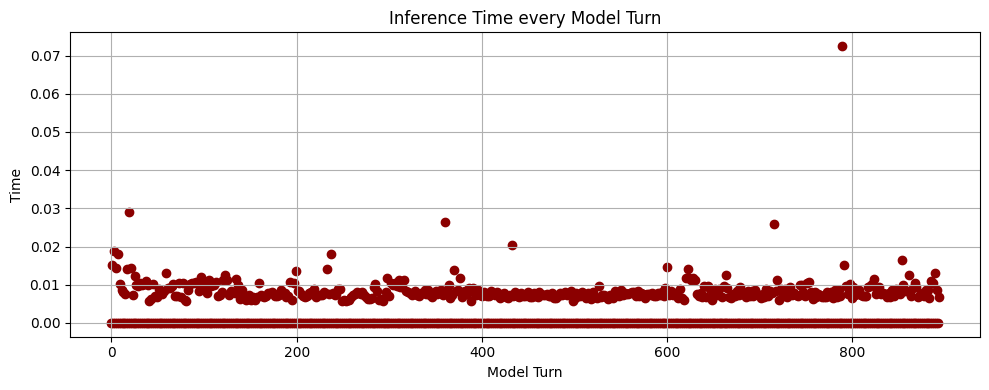

In [3]:
from OLA.constants import Ranking, Controller, POV

# Sample random formations
blue_formation = list(
    Player.get_sensible_random_formation(
        piece_list=Ranking.SORTED_FORMATION)
)
red_formation = list(
    Player.get_sensible_random_formation(
        piece_list=Ranking.SORTED_FORMATION)
)

match_simulator = ModelTestingSimulator(formations=[blue_formation, red_formation],
                                  controllers=[
                                      Controller.RANDOM, TestingController.MODEL],
                                  save_data=False,
                                  pov=POV.WORLD)
match_simulator.start(iterations=10)